In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import time
import re
import pandas as pd

# 웹 드라이버 설정 (Chrome 예제)
driver = webdriver.Chrome()

# 기본 URL 설정
base_url = 'https://career.programmers.co.kr/job?page=1&order=recent&job_category_ids=12'
driver.get(base_url)

# 데이터의 총량 추출
total_positions_text = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.CLASS_NAME, 'header-left'))
).text
total_positions = int(re.findall(r'\d+', total_positions_text)[0])
print(f"Total positions: {total_positions}")

# 데이터 크롤링 함수
def crawl_data(driver, total_positions):
    data = []
    page_number = 1
    while len(data) < total_positions:
        print(f"Scraping page {page_number}")
        
        # 현재 페이지의 목표 데이터 추출
        elements = WebDriverWait(driver, 10).until(
            EC.presence_of_all_elements_located((By.CLASS_NAME, 'list-position-tags'))
        )
        if not elements:
            print(f"No elements found on page {page_number}")
        
        for elem in elements:
            data.append(elem.text)
        
        print(f"Collected {len(data)} positions so far")

        # 다음 페이지로 이동
        try:
            next_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.CSS_SELECTOR, '#tab_position > div.flex-center > ul > li:nth-child(8) > span'))
            )
            next_button.click()
            time.sleep(1)  # 스크롤 후 잠시 대기
            next_button.click()
            page_number += 1
            time.sleep(5)  # 페이지 로드 대기
        except Exception as e:
            print(f"Error: {e}")
            break

    return data[:total_positions]  # 만약 데이터를 초과해서 수집하면 total_positions 만큼만 반환

# 데이터 크롤링
data = crawl_data(driver, total_positions)

# 데이터 프레임으로 변환
df = pd.DataFrame(data, columns=['Position'])

# 데이터가 비어 있는지 확인
if df.empty:
    print("데이터 프레임이 비어 있습니다. 요소 선택기나 페이지 로드 시간을 점검하세요.")
else:
    # CSV 파일로 저장
    df.to_csv('programmers_positions.csv', index=False)
    print("크롤링 완료 및 programmers_positions.csv 파일 저장")

# 드라이버 종료
driver.quit()


Total positions: 129
Scraping page 1
Collected 24 positions so far


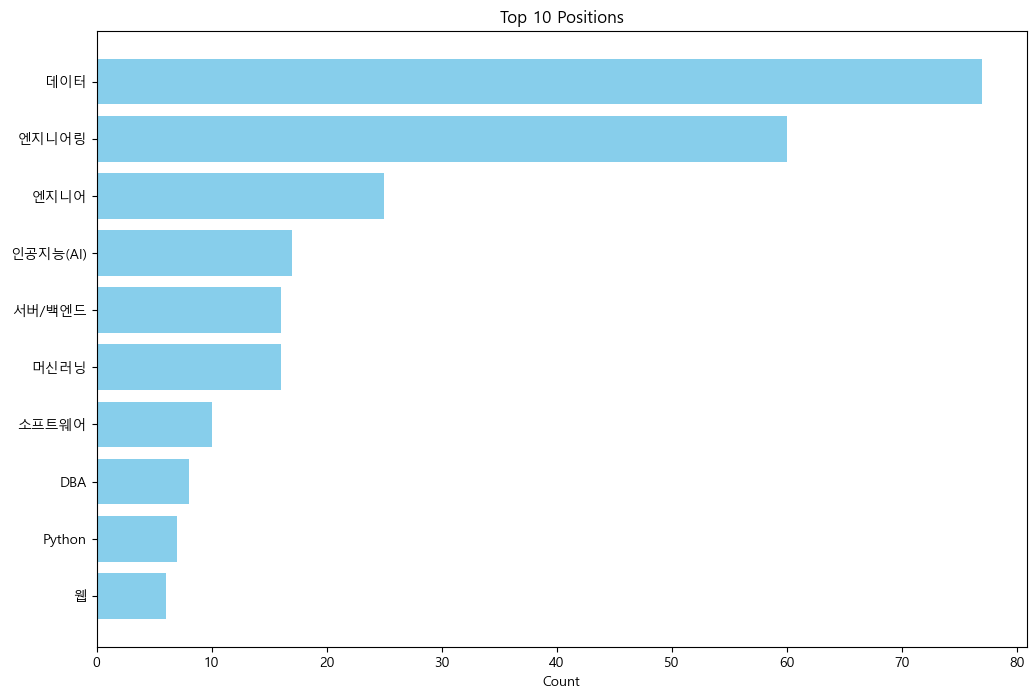

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc


# CSV 파일 불러오기
file_path = 'programmers_positions.csv'
df = pd.read_csv(file_path)


font_path = 'C:/Windows/Fonts/malgun.ttf'
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False


def preprocess_position(position):
    if '외' in position:
        position = position.split('외')[0]
    return position.split()

# 포지션 전처리
processed_positions = df['Position'].apply(preprocess_position)

# 리스트를 펼쳐서 모든 단일 포지션을 포함하는 시리즈 생성
all_positions = processed_positions.explode()

# 각 포지션의 발생 빈도 계산
position_counts = all_positions.value_counts().reset_index()
position_counts.columns = ['Position', 'Count']

# 상위 10개 데이터 추출
top_10_positions = position_counts.head(10)

# 상위 10개 데이터 확인
top_10_positions

# 시각화
plt.figure(figsize=(12, 8))
plt.barh(top_10_positions['Position'], top_10_positions['Count'], color='skyblue')
plt.xlabel('Count')
plt.title('Top 10 Positions')
plt.gca().invert_yaxis()  # 상위 항목이 위로 오도록 반전
plt.show()